# DAQ（v1）

## チャンネルに閾値（スレッショルド）を設定してトリガーする

アナログ入力信号がある電圧を越えた場合に、データを取得できるようにします。

**Note:**  

アナログ入力信号の範囲は、RedPitaya本体のジャンパーピンで設定できます。
HV設定の場合は±20 V、LV設定の場合は±1 Vになります。

For more information, please read the following [chapter](https://redpitaya.readthedocs.io/en/latest/developerGuide/hardware/125-14/fastIO.html#analog-inputs).

Create a loop-back from fast analog outputs to fast analog inputs, as shown in the picture below.  
Please make sure the jumpers are set to ±1 V (LV).

![Fast loop back](../img/FastIOLoopBack.png "Example of the fast loop back.")

In [1]:
#!date -s "2024-02-02 17:14:00+09:00"


In [2]:
!date +%Y-%m-%dT%H:%M:%S

2024-02-02T09:05:17


In [3]:
import time
import datetime
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

print(f"NumPy: {np.__version__}")
print(f"Pandas: {pd.__version__}")

NumPy: 1.21.5
Pandas: 1.3.5


## Libraries and FPGA image

We need the additional functionality of *numpy* and *matplotlib* for data plotting and faster array operations.

RedPitayaを操作するパッケージを読み込んで、初期化します。

In [4]:
from rp_overlay import overlay
import rp

fpga = overlay()
rp.rp_Init()

Check FPGA [OK].


0

## Macros（マクロ）

チュートリアルで利用するマクロの説明

Here is a complete list of macros that will come in handy when customising this notebook. The marcos are a part of the **rp** library.

- **Decimation（デシメーション）** - RP_DEC_1, RP_DEC_2, RP_DEC_4, RP_DEC_8, RP_DEC_16, RP_DEC_32, RP_DEC_64, RP_DEC_128, RP_DEC_256, RP_DEC_512, RP_DEC_1024, RP_DEC_2048, RP_DEC_4096, RP_DEC_8192, RP_DEC_16384, RP_DEC_32768, RP_DEC_65536 

- **Acquisition trigger（トリガー）** - RP_TRIG_SRC_DISABLED, RP_TRIG_SRC_NOW, RP_TRIG_SRC_CHA_PE, RP_TRIG_SRC_CHA_NE, RP_TRIG_SRC_CHB_PE, RP_TRIG_SRC_CHB_NE, RP_TRIG_SRC_EXT_PE, RP_TRIG_SRC_EXT_NE, RP_TRIG_SRC_AWG_PE, RP_TRIG_SRC_AWG_NE
- **Acquisition trigger state（トリガー状態）** - RP_TRIG_STATE_TRIGGERED, RP_TRIG_STATE_WAITING
- **Buffer size（バッファーサイズ）** - ADC_BUFFER_SIZE, DAC_BUFFER_SIZE
- **Fast analog channels（アナログ信号入力）** - RP_CH_1, RP_CH_2

STEMlab 125-14 4-Input only:
- **Fast analog channels** - RP_CH_3, RP_CH_4
- **Acquisition trigger** - RP_TRIG_SRC_CHC_PE, RP_TRIG_SRC_CHC_NE, RP_TRIG_SRC_CHD_PE, RP_TRIG_SRC_CHD_NE


## Theory

データを取得する場合に、知っておく必要がある用語集

- **Triggering moment（トリガータイミング）** - The point in time where the trigger condition is met and the instrument starts capturing data. 
- **Trigger condition（トリガー条件）** - Composed of trigger level and signal front.
- **Trigger level（トリガーレベル）** - the value of the input signal in Volts at which the acquisition will start
- **Signal front** - also reffered to as **positive/negative edge** (mostly used for digital logic). The point in time where a signal becomes *high* is called a positive edge, while the moment it becomes *low* is a negative edge. With analog signals, this refers to how the signal crosses the trigger level. A positive edge means the signal must be lower and rise to the trigger level, and for a negative edge, the signal must be higher and fall to the trigger level to meet the trigger condition.  
- **Decimation（デシメーション）** - データを保存する時に、スキップするサンプル数。この値を10に設定した場合、10点ごとにデータを保存し、残り9点は除外されます。間接的にサンプリング周波数を決定します。
- **Averaging（平均化）** - デシメーションの値が1より大きい時、保存される値は、スキップしたサンプリング点の平均値になります。By default, this is turned *on*.
- **Acquisition units（データの単位）** - データの単位は*RAW*と*Volts*を設定できます。*RAW*はRed PitayaのADC値です。*Volts*はADC値を電圧に変換した値です。By default, this is set to *Volts*.
- **Trigger delay（トリガー遅延）** - トリガータイミングを遅延させるサンプル数を設定します。この値を0にすると、トリガータイミングは取得したデータ（のバッファサイズ）の中央になります。正の値を指定すると、トリガータイミングはバッファーの開始位置に移動します。負の値は終了位置に移動します。By default, this is set to 0.

![Python buffer](../img/python_buffer.png "Acquisition buffer")

## Trigger level（トリガーレベル）

For the purposes of demonstartion we will first generate a signal on Red Pitaya's outputs and then acquire it on the inputs. The so-called "loopback" does not have many applications in practice, but is perfect for this demonstration. In practice, an external signal is applied directly to the Red Pitaya's inputs.

In [5]:
# Generator parameters
# channel = rp.RP_CH_1
# channel2 = rp.RP_CH_2
# waveform = rp.RP_WAVEFORM_SINE
# freq = 100000
# ampl = 1.0


Above are the parameters for the generation and acquisition. 
We set the acquisition trigger to IN1 positive edge 0.5 V.

Now, we are going to reset both acquisition and generation parameters and configure the generator.

データを取得するパラメーターを設定する
- デシメーション：データのサンプリング率
- トリガーレベル：トリガーの電圧値と信号の向き
- トリガーの遅延：

In [6]:
# Acquisition paramters
## デシメーション
## トリガーレベル
## トリガー遅延
## トリガーソース
## バッファーサイズ
dec = rp.RP_DEC_1
trig_lvl = 0.1
trig_dly = 0
acq_trig_sour = rp.RP_TRIG_SRC_CHA_PE
N = 16384
# N = 4000

# DAQのリセット
rp.rp_AcqReset()

##### DAQの設定 #####
# デシメーションを設定する
rp.rp_AcqSetDecimation(rp.RP_DEC_1)

# トリガーを設定する
rp.rp_AcqSetTriggerLevel(rp.RP_T_CH_1, trig_lvl)
rp.rp_AcqSetTriggerDelay(trig_dly)

0

DAQのパラメータを設定したら、DAQをスタートし、トリガーソースを設定します。
このコマンドの順番はとても大切です！
**Acquisition must be started before the acquisition trigger is specified!**
（トリガーソースを設定する前に、DAQをスタートさせてください！！！）

In [7]:
# Start Data Acquisition
print("DAQ start")
rp.rp_AcqStart()
time.sleep(0.1)

# Specify trigger - input 1 positive edge
rp.rp_AcqSetTriggerSrc(acq_trig_sour)
time.sleep(0.1)

DAQ start


波形データを取得するメインのプログラム

In [8]:
# rp.rp_GenTriggerOnly(channel)       # Trigger generator

# Trigger state
while 1:
    trig_state = rp.rp_AcqGetTriggerState()[1]
    if trig_state == rp.RP_TRIG_STATE_TRIGGERED:
        break

# Fill state
while 1:
    if rp.rp_AcqGetBufferFillState()[1]:
        break


# Get data
# RAW
channels = [rp.RP_CH_1, rp.RP_CH_2]
# channels = [rp.RP_CH_1]
waveforms = {}
for ch in channels:
    # RAW
    ibuff = rp.i16Buffer(N)
    res = rp.rp_AcqGetOldestDataRaw(ch, N, ibuff.cast())[1]

    # Volts
    fbuff = rp.fBuffer(N)
    res = rp.rp_AcqGetOldestDataV(ch, N, fbuff)[1]

    # データを保存する配列を作成する
    data_raw = np.zeros(N, dtype=int)
    data_volts = np.zeros(N, dtype=float)

    for i in range(0, N, 1):
        data_raw[i] = ibuff[i]
        data_volts[i] = fbuff[i]

    key1 = f"raw_{ch+1}"
    key2 = f"v_{ch+1}"
    waveforms[key1] = data_raw
    waveforms[key2] = data_volts

With *rp_AcqGetTriggerState()* and *rp_AcqGetBufferFillState()*, we are checking the second returned parameter (the first one is function execution success).

After confirming that the trigger condition was met and that the data buffer is full, the data can be acquired from the Red Pitaya. We can use either of the two presented functions, depending on whether we want RAW data or Volts directly.

Next, we will convert the data to a numpy array for easy plotting.

And here is the data we have been looking for, nicely displayed in a graph. As you can see from the X-axis, Red Pitaya returns a 16384-sample long buffer of acquired data. The triggering moment is in the middle, around the 8192th sample (the trigger delay is 0), so half the data was acquired before the trigger and half the data after it. If the transition events are not what we are looking for, we can increase the trigger delay to get more data points after the triggering moment or decrease it (negative numbers) to get more information before the triggering event.

### Note
There are a lot of different commands for the Acquisition. The list of available functions is quite an achievement to read through, so from now on, please refer to the *C and Python API section* of the [Command table](https://redpitaya.readthedocs.io/en/latest/appsFeatures/remoteControl/command_list.html#list-of-supported-scpi-api-commands) for all available commands.


In [9]:
unixtime = time.time()
now = datetime.datetime.now()

data = pd.DataFrame(waveforms)
data["x"] = data.index
data["timestamp"] = now
data["unixtime"] = unixtime

t = now.strftime("%Y%m%d_%H%M%S")
fname = f"data/cw_data_{t}.csv"
data.to_csv(fname, index=False)

In [10]:
data.plot.scatter(x="x", y="v_1")

<AxesSubplot:xlabel='x', ylabel='v_1'>

<AxesSubplot:xlabel='x', ylabel='v_2'>

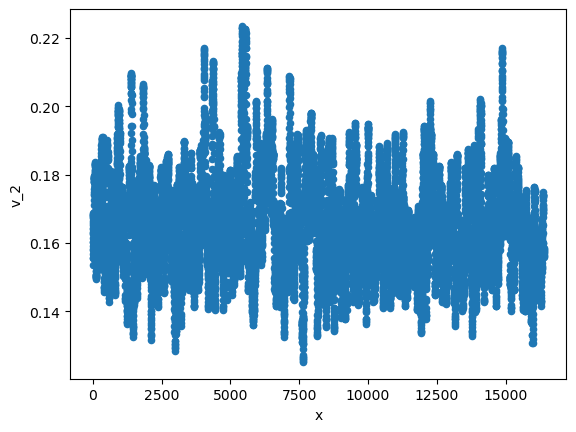

In [11]:
data.plot.scatter(x="x", y="v_2")